In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import cooler
import serpentine as sp
import matplotlib.pyplot as plt
samples = pd.read_csv('../../samples.tsv', sep='\t', comment="#")
hgt = pd.DataFrame({
    'chrom': ['scaffold_34', 'scaffold_2'],
    'start': [27492, 1832629],
    'end': [28616, 1834423],
    'id': ['FUN_01063', 'FUN_005671']
})

In [69]:
merged_u = cooler.Cooler('../../data/output/cool/uninfected_merged_subsampled.cool')
merged_i= cooler.Cooler('../../data/output/cool/infected_merged_subsampled.cool')

### Zooms around HGT

Regions around putative HGT are plotted below for uninfected, infected and ratio. All maps are serpentine-binned.
All replicated in each condition were pooled separately, and the whole genome merged matrices were subsampled to the same coverage.

<IPython.core.display.Javascript object>


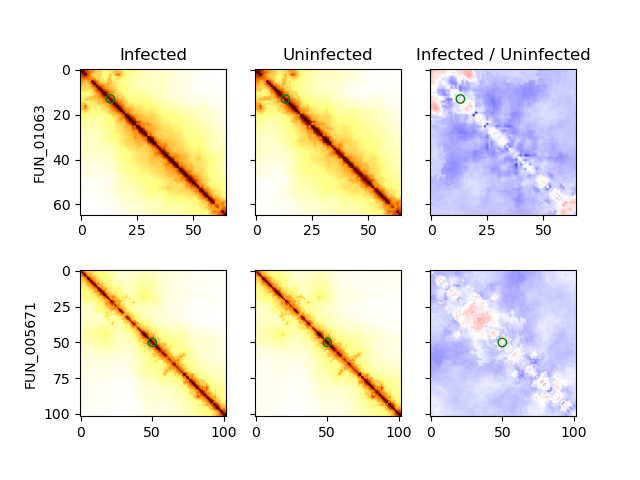

2020-09-09 19:37:14.199035 Starting 20 binning processes...
0	 Total serpentines: 2145 (100.0 %)
1	 Total serpentines: 1448 (67.50582750582751 %)
2	 Total serpentines: 593 (27.645687645687644 %)
3	 Total serpentines: 292 (13.613053613053612 %)
4	 Total serpentines: 229 (10.675990675990676 %)
5	 Total serpentines: 215 (10.023310023310023 %)
6	 Total serpentines: 212 (9.883449883449883 %)
7	 Total serpentines: 211 (9.836829836829837 %)
7	 Over: 2020-09-09 19:37:14.275634
0	 Total serpentines: 2145 (100.0 %)
1	 Total serpentines: 1455 (67.83216783216783 %)
2	 Total serpentines: 568 (26.48018648018648 %)
3	 Total serpentines: 309 (14.405594405594405 %)
4	 Total serpentines: 224 (10.442890442890443 %)
5	 Total serpentines: 206 (9.603729603729604 %)
6	 Total serpentines: 205 (9.557109557109557 %)
7	 Total serpentines: 203 (9.463869463869464 %)
7	 Over: 2020-09-09 19:37:14.330224
0	 Total serpentines: 2145 (100.0 %)
1	 Total serpentines: 1468 (68.43822843822844 %)
2	 Total serpentines: 573 (2

1	 Total serpentines: 3511 (66.83799733485627 %)
2	 Total serpentines: 1323 (25.185608223872073 %)
3	 Total serpentines: 552 (10.508280982295831 %)
4	 Total serpentines: 337 (6.415381686655245 %)
5	 Total serpentines: 271 (5.158956786598134 %)
6	 Total serpentines: 261 (4.9685893774985725 %)
7	 Total serpentines: 259 (4.93051589567866 %)
7	 Over: 2020-09-09 19:37:15.605848
0	 Total serpentines: 5253 (100.0 %)
1	 Total serpentines: 3530 (67.19969541214545 %)
2	 Total serpentines: 1312 (24.976204073862554 %)
3	 Total serpentines: 570 (10.850942318675044 %)
4	 Total serpentines: 338 (6.434418427565201 %)
5	 Total serpentines: 274 (5.216067009328003 %)
6	 Total serpentines: 259 (4.93051589567866 %)
7	 Total serpentines: 259 (4.93051589567866 %)
7	 Over: 2020-09-09 19:37:15.721589
0	 Total serpentines: 5253 (100.0 %)
1	 Total serpentines: 3543 (67.44717304397487 %)
2	 Total serpentines: 1291 (24.576432514753474 %)
3	 Total serpentines: 572 (10.889015800494954 %)
4	 Total serpentines: 337 (6

In [70]:
%matplotlib notebook
# Define window size around genes of interest
zoom_radius = 100000
# We'll show 1 gene per row, 3 panels each (infected, uninfected, ratio)
fig, ax = plt.subplots(hgt.shape[0], 3, sharex='row', sharey='row')
ax[0, 0].set_title("Infected")
ax[0, 1].set_title("Uninfected")
ax[0, 2].set_title("Infected / Uninfected")

# Iterate over HGTs
for i, gene in hgt.iterrows():
    # Transform gene coords into UCSC string (chr:start-end), use max to prevent negative coords
    region = f"{gene.chrom}:{max(0, gene.start - zoom_radius)}-{gene.end + zoom_radius}"
    # Compute pixel coordinate of the gene in the zoom matrix
    gene_coord = zoom_radius//2000 if gene.start > zoom_radius else (zoom_radius - (zoom_radius - gene.start))//2000
    # Extract matrices for both conditions
    uninf = merged_u.matrix(balance=False).fetch(region)
    inf = merged_i.matrix(balance=False).fetch(region)
    # Use serpenting for adaptative binning + ratio
    serpi, serpu, serprat = sp.serpentin_binning(inf, uninf, triangular=True, parallel=1, iterations=20)
    # Plot all 3 matrices
    ax[i, 0].imshow(np.log(serpi), cmap="afmhot_r")
    ax[i, 1].imshow(np.log(serpu), cmap="afmhot_r")
    ax[i, 2].imshow(serprat, cmap='bwr', vmax=2, vmin=-2)
    ax[i, 0].set_ylabel(gene['id'])
    # Add a circle on the image where the gene is located
    for j in range(3):
        ax[i, j].scatter(gene_coord, gene_coord, fc='none', ec='green', marker='o')

plt.show()

In [71]:
for i, spl in enumerate(samples.library):
    spl_path = f"../../data/output/chromosight/{spl}/loops_quant.tsv"
    if i:
        spl_loops = pd.read_csv(spl_path, sep='\t', usecols=[6, 7, 8]).rename(columns={'score': spl})
        merged_loops = merged_loops.merge(spl_loops, left_on=['bin1', 'bin2'], right_on=['bin1', 'bin2'])
    else:
        merged_loops = pd.read_csv(spl_path, sep='\t')
        merged_loops = merged_loops.rename(columns={"score": spl}).drop(['pvalue', 'qvalue'], axis=1)

In [72]:
%matplotlib notebook
import matplotlib.pyplot as plt
sizes = (merged_loops.start2 - merged_loops.start1)
sizes = sizes[sizes < 200000] / 1000
a = plt.hist(sizes, 30)
plt.title("Distribution of loop sizes in A. castellanii str. C3")
plt.xlabel("Loop size [kbp]")
plt.ylabel("# Loops")




<IPython.core.display.Javascript object>

Text(0, 0.5, '# Loops')

In [73]:
combined_loops = merged_loops.melt(value_vars=samples.library.values, id_vars=merged_loops.columns[:5])
combined_loops = combined_loops.rename(columns={'variable': 'sample', 'value': 'score'})

In [74]:
samples = samples.set_index(samples.library)
combined_loops['condition'] = combined_loops['sample'].apply(lambda x: samples.condition[x])
combined_loops['size'] = combined_loops['start2'] - combined_loops['start1']

In [75]:
%matplotlib notebook
import seaborn as sns
ax = sns.regplot(data=combined_loops, x='size', y = 'score')
#ax.set_xscale('log')

<IPython.core.display.Javascript object>

In [76]:
uninf_loops = (
    combined_loops.loc[combined_loops.condition == 'uninfected', :]
    .groupby(['chrom1', 'start1', 'chrom2', 'start2'])
    .score
    .agg(np.nanmedian)
    .reset_index()
)

In [77]:
inf_loops = (
    combined_loops.loc[combined_loops.condition == 'infected', :]
    .groupby(['chrom1', 'start1', 'chrom2', 'start2'])
    .score
    .agg(np.nanmedian)
    .reset_index()
)

In [78]:
med_loops = pd.merge(inf_loops, uninf_loops, on=['chrom1', 'start1', 'chrom2', 'start2'],suffixes=['_i', '_u'])

In [79]:
%matplotlib notebook
lo_perc, up_perc = 2.5, 97.5
ldiffs = med_loops.score_i - med_loops.score_u
ldiffs = lratios[~np.isnan(lratios)]
a = plt.hist(lratios, 40)
plt.axvline(0, c='black')
plt.axvline(np.percentile(ldiffs, up_perc), ls=':')
plt.axvline(np.percentile(ldiffs, lo_perc), ls=':')
plt.title("Loop score differences (infected - uninfected)")
plt.xlabel("log2(median(infected) / median(uninfected))")

<IPython.core.display.Javascript object>

Text(0.5, 0, 'log2(median(infected) / median(uninfected))')

In [80]:
%matplotlib notebook
med_loops['col'] =  (lratios < np.percentile(ldiffs, lo_perc)) | (ldiffs > np.percentile(ldiffs, up_perc))
sns.lmplot(data=med_loops, x="score_i", y="score_u", hue="col", fit_reg=False)
plt.plot([0, .5], [0, .5], ls=':', c='r')

<IPython.core.display.Javascript object>

In [81]:
import scipy.stats as ss
ss.ttest_rel(med_loops.score_u, med_loops.score_i)

Ttest_relResult(statistic=-22.93759503163114, pvalue=1.7773007625744533e-88)

In [82]:
ss.wilcoxon(med_loops.score_u, med_loops.score_i,)

WilcoxonResult(statistic=32549.0, pvalue=2.8322605275230456e-73)

In [83]:
boot_means = np.zeros(1000)
for i, boot in enumerate(range(1000)):
    resample = np.random.choice(ldiffs, size=len(ldiffs), replace=True)
    boot_means[i] = np.mean(resample)
    

<IPython.core.display.Javascript object>


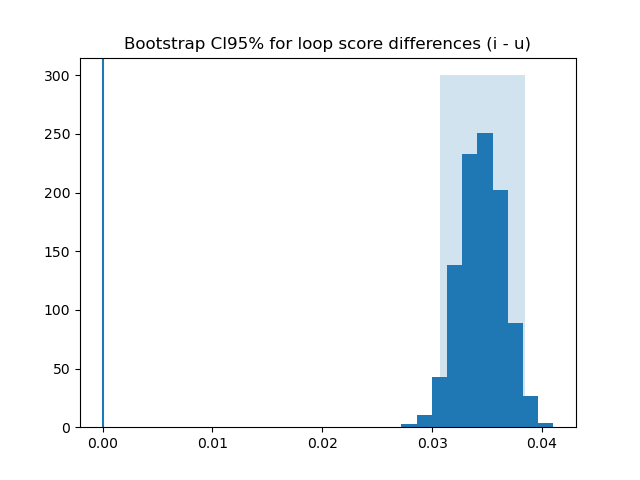

Text(0.5, 1.0, 'Bootstrap CI95% for loop score differences (i - u)')

In [95]:
%matplotlib notebook
from matplotlib.patches import Rectangle
fig, ax = plt.subplots(1)
left = np.percentile(boot_means, 2.5)
right = np.percentile(boot_means, 97.5)
ax.add_patch(Rectangle((left, 0), width=right-left, height=300, alpha=0.2))
f = plt.hist(boot_means)
plt.axvline(0)
plt.title("Bootstrap CI95% for loop score differences (i - u)")